<a href="https://colab.research.google.com/github/syphax/solar-data/blob/feb01/nb/Solar_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook analyses and visualizes output from my VT PV system.

To run with the provided data, you need Google Drive, and you need to copy the data from https://github.com/syphax/solar-data/tree/main/data to `/My Drive/Data/Solar`

_TODO: Load the data directly from the GitHub repo._

# Setup

In [1]:
import os

from datetime import datetime
import pytz

import numpy as np
import pandas as pd

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

This loads data that was downloaded from [Green Mountain Power's website](https://greenmountainpower.com/account/usage/).

GMP has an excellent UI for reporting usage, and provides downloadable data in 15 minute increments (either CSV or Green Button XML). *Unfortunately* it only supports manual data downloads in 15 day (max) chunks. 

This data gets concatenated and cleaned in the `Clean_GMP_Solar_Data.ipynb` script.

Fields in the cleaned up dataset are:
* `Service`: Is this consumption, generation?
* `IntervalStart`: Timestamp; format is `yyyy-MM-dd-hh:mm:ss`
* `IntervalEnd`: Same, 15 minutes later. Redundant but explicit!
* `dt_start`: IntervalStart, converted to EST (correcting for DST)
* `dt_end`: IntervalEnd, converted to EST (correcting for DST)
* `Quantity`: Amount of electricity generated
* `UnitOfMeasure`: I love that they have an explicit UoM field!
* `kWh`: Quantity converted to kWh


## Prep

In [3]:
path = '/content/drive/MyDrive/Data/Solar/'

In [4]:
# We use the jointed script created in Clean_GMP_Solar_Data.ipynb
joined_input_file = os.path.join(path, 'full_dataset.csv')


## Load

In [5]:
df_energy_data = pd.read_csv(joined_input_file)

In [6]:
from pytz import timezone

est = pytz.timezone('US/Eastern')

# TODO: Add timezone attribute (note: we adjusted for DST in the pre-process script)
for f in ['dt_start', 'dt_end']:
 df_energy_data[f] = pd.to_datetime(df_energy_data[f], utc=True).dt.tz_convert(est)


In [7]:
df_solar_data = df_energy_data[df_energy_data['Service']=='NGEN'].copy()

In [8]:
for c in ['dt_start', 'dt_end']:  

  # Compute diffs vs prior record
  df_solar_data['diff_' + c] = df_solar_data[c].diff()

  # Add year, month, day, hour, minutes:

  df_solar_data[c + '_year'] = df_solar_data[c].dt.year
  df_solar_data[c + '_month'] = df_solar_data[c].dt.month
  df_solar_data[c + '_week'] = df_solar_data[c].dt.isocalendar().week
  df_solar_data[c + '_2weeks'] = np.ceil(df_solar_data[c].dt.isocalendar().week / 2.0) # Useful resolution
  df_solar_data[c + '_day'] = df_solar_data[c].dt.day
  
  # Altair doesn't like date types very much, so this is basically a rounded datetime
  df_solar_data[c + '_dt'] = pd.to_datetime(df_solar_data[c].dt.date)
  
  df_solar_data[c + '_hour'] = df_solar_data[c].dt.hour
  df_solar_data[c + '_minute'] = df_solar_data[c].dt.minute

  df_solar_data[c + '_hrmin'] = df_solar_data[c + '_hour'] + df_solar_data[c + '_minute'] / 60.0


In [9]:
# 15 minute increment:

fmt = '%Y-%m-%d-%H:%M:%S'

d1 = datetime.strptime('2022-01-01-00:00:00', fmt)
d2 = datetime.strptime('2022-01-01-00:15:00', fmt)

diff_mins = (d2-d1)

In [10]:
# This should show the start of the series, plus some daylight savings impaired records!

df_solar_data[df_solar_data['diff_dt_start'] != diff_mins]

,IntervalStart,IntervalEnd,Quantity,UnitOfMeasure,kWh,dt_start_raw,dt_end_raw,dt_start,dt_end,Service,...,diff_dt_end,dt_end_year,dt_end_month,dt_end_week,dt_end_2weeks,dt_end_day,dt_end_dt,dt_end_hour,dt_end_minute,dt_end_hrmin
0,2021-05-23-00:00:00,2021-05-23-00:15:00,0.0,kWh,0.0,2021-05-23 00:00:00,2021-05-23 00:15:00,2021-05-23 00:00:00-04:00,2021-05-23 00:15:00-04:00,NGEN,...,NaT,2021.0,5.0,20,10.0,23.0,2021-05-23,0.0,15.0,0.25
59136,2021-10-24-01:00:00,2021-10-24-01:15:00,0.0,kWh,0.0,2021-10-24 01:00:00,2021-10-24 01:15:00,2021-10-24 01:00:00-04:00,2021-10-24 01:15:00-04:00,NGEN,...,0 days 01:15:00,2021.0,10.0,42,21.0,24.0,2021-10-24,1.0,15.0,1.25
64512,2021-11-07-02:00:00,2021-11-07-02:15:00,0.0,kWh,0.0,2021-11-07 02:00:00,2021-11-07 02:15:00,2021-11-07 02:00:00-05:00,2021-11-07 02:15:00-05:00,NGEN,...,NaT,2021.0,11.0,44,22.0,7.0,2021-11-07,2.0,15.0,2.25
201076,2022-11-06-02:00:00,2022-11-06-02:15:00,0.0,kWh,0.0,2022-11-06 02:00:00,2022-11-06 02:15:00,2022-11-06 02:00:00-05:00,2022-11-06 02:15:00-05:00,NGEN,...,NaT,2022.0,11.0,44,22.0,6.0,2022-11-06,2.0,15.0,2.25


# Summarize

## Output by Day

In [11]:
df_solar_data_sums_by_day = df_solar_data.groupby(['dt_start_dt'], as_index=False).agg({'Quantity':'sum'})

df_solar_data_sums_by_day['rolling_07'] = df_solar_data_sums_by_day['Quantity'].rolling(window=7, center=True).mean()
df_solar_data_sums_by_day['rolling_14'] = df_solar_data_sums_by_day['Quantity'].rolling(window=14, center=True).mean()
df_solar_data_sums_by_day['rolling_28'] = df_solar_data_sums_by_day['Quantity'].rolling(window=28, center=True).mean()
df_solar_data_sums_by_day['rolling_60'] = df_solar_data_sums_by_day['Quantity'].rolling(window=60, center=True).mean()

In [12]:
# Time series by day with rolling 60 day average (centered) - Altair version

alt.data_transformers.disable_max_rows()
ch_title = alt.TitleParams('Daily Production with 60 Day Moving Avg', anchor='middle')

ch_raw = alt.Chart(df_solar_data_sums_by_day, title=ch_title).mark_bar(size=1).encode(
    x=alt.X('dt_start_dt:T', title='Date'),
    y=alt.Y('Quantity:Q', title = 'Kwh / Day')
)

ch_roll = alt.Chart(df_solar_data_sums_by_day).mark_line().encode(
    x=alt.X('dt_start_dt:T'),
    y=alt.Y('rolling_60:Q'),
    color=alt.value("#220099")
)

ch = ch_raw + ch_roll

ch.display()

alt.LayerChart(...)

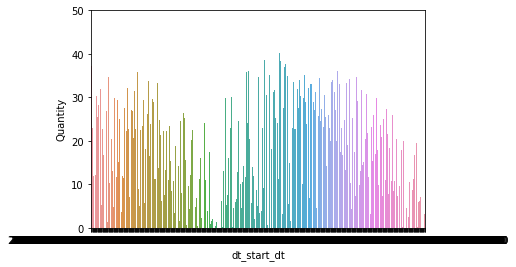

In [13]:
# Seaborn version

fig, ax1 = plt.subplots() #figsize=(12,6))

ax1.set_ylim(0,50)
sns.barplot(data = df_solar_data_sums_by_day, x='dt_start_dt', y='Quantity', ax=ax1) # alpha=1,

# Need to debug this- adding the moving average messes up the bars somehow:

#ax2 = ax1.twinx()
#ax2.set_ylim(0,50)
#sns.lineplot(data = df_solar_data_sums_by_day, y='rolling_60', marker='', ax=ax2)

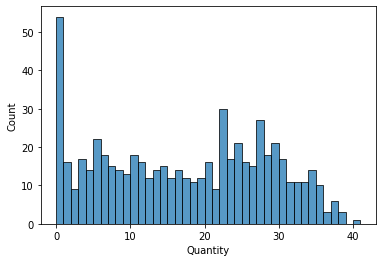

In [14]:
# Distribution of kWh by day, Narrow bins

sns.histplot(data=df_solar_data_sums_by_day, x="Quantity", binwidth = 1)

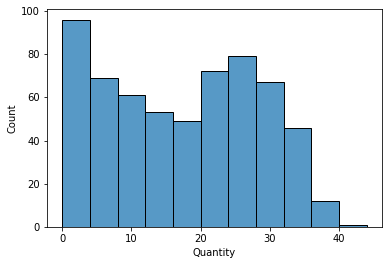

In [15]:
# Distribution of kWh by day, Wide bins

sns.histplot(data=df_solar_data_sums_by_day, x="Quantity", binwidth = 4)

## Output by Time of Day

### Output by Month and Min Time Interval

In [16]:
df_solar_data_sums_by_t_mo = df_solar_data.groupby(['dt_start_month', 'dt_start_hrmin'], as_index=False).agg({'Quantity':'mean'})
df_solar_data_sums_by_t_mo['kW'] = 4.0 * df_solar_data_sums_by_t_mo['Quantity'] # To convert 15 min intervals to hourly kW

Text(0, 0.5, 'Avg. kW')

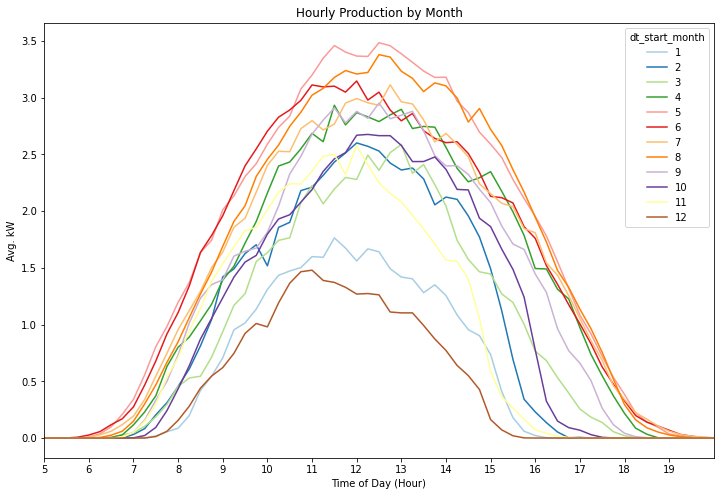

In [18]:
# Plot average daily trend

df_chart = df_solar_data_sums_by_t_mo

fig, ax = plt.subplots(figsize = (12,8))    

# TODO: Improve the palette!

fig = sns.lineplot(data=df_chart, x='dt_start_hrmin', y='kW', hue='dt_start_month', palette='Paired').set(title='Hourly Production by Month')

ax.set_xlim(5,20)
ax.set_xticks(range(5, 20))

plt.xlabel("Time of Day (Hour)")
plt.ylabel("Avg. kW")

### Distributions of Hourly Production

In [19]:
df_solar_data_sums_by_hour = df_solar_data.groupby(['dt_start_dt', 'dt_start_hour'], as_index=True).agg({'Quantity':'sum'})

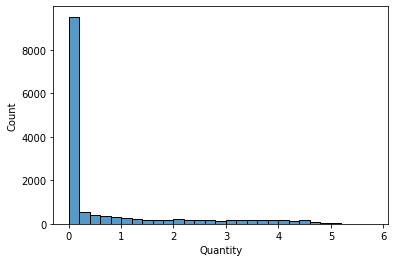

In [20]:
# Histogram of production by hour: 

sns.histplot(data=df_solar_data_sums_by_hour, x="Quantity", binwidth = 0.2)

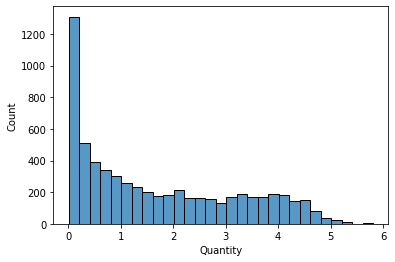

In [21]:
# Lots of zero hours (night, etc)- let's remove those:

sns.histplot(data=df_solar_data_sums_by_hour[df_solar_data_sums_by_hour['Quantity'] > 0.0], x="Quantity", binwidth = 0.2)

### Production Heatmap by Hour and Day

In [22]:
df_solar_hourly_table = df_solar_data_sums_by_hour.unstack(0).droplevel(0, axis=1)

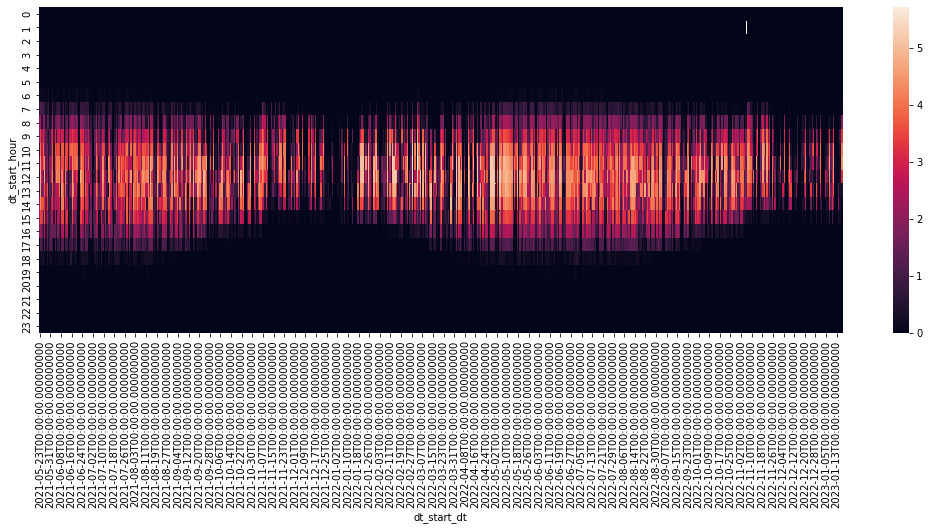

In [23]:
# Plot heatmap of date x hour of day
# TODO: Need to format dates on x-axis!
# TODO: Need to flip y-axis

fig, ax = plt.subplots(figsize = (18,6))    
fig = sns.heatmap(df_solar_hourly_table)


In [24]:
df_solar_data_sums_by_hour_un = df_solar_data_sums_by_hour.reset_index()

In [25]:
# Average production by hour of day; no adjustments for start, end dates of series:

# 2 season - Winter = October - March, inclusive (not quite aligned to equinoxes)

df_solar_data_sums_by_hour_un['season_ws'] = 'Winter'
df_solar_data_sums_by_hour_un['season_ws'] = np.where((df_solar_data_sums_by_hour_un['dt_start_dt'].dt.month > 3) & 
                                                      (df_solar_data_sums_by_hour_un['dt_start_dt'].dt.month <=9), 
                                                      'Summer', df_solar_data_sums_by_hour_un['season_ws'])

# Overall sum by hour
df_avg_by_hour_all = df_solar_data_sums_by_hour_un.groupby('dt_start_hour', as_index=False).agg({'Quantity':'mean'})
df_avg_by_hour_all['season_ws'] = 'All'

df_avg_by_hour_ws = df_solar_data_sums_by_hour_un.groupby(['season_ws', 'dt_start_hour'], as_index=False).agg({'Quantity':'mean'})

# Append the two together
df_avg_by_hour_ws = pd.concat([df_avg_by_hour_all, df_avg_by_hour_ws], axis=0)

#df_avg_by_hour_ws.groupby(['season_ws']).agg({'dt_start_hour':'count', 'Quantity':'sum'})

display(df_avg_by_hour_ws.groupby(['dt_start_hour', 'season_ws']).agg({'Quantity':'sum'}).unstack(-1))

Quantity                    
season_ws           All    Summer    Winter
dt_start_hour                              
0              0.000000  0.000000  0.000000
1              0.000000  0.000000  0.000000
2              0.000000  0.000000  0.000000
3              0.000000  0.000000  0.000000
4              0.000000  0.000000  0.000000
5              0.000248  0.000478  0.000000
6              0.024050  0.045032  0.001409
7              0.285587  0.447293  0.111100
8              0.947025  1.238981  0.631993
9              1.623025  1.941401  1.279485
10             2.168678  2.572070  1.733402
11             2.528083  2.984554  2.035533
12             2.592545  3.070796  2.076495
13             2.392430  2.909395  1.834605
14             2.033917  2.599713  1.423402
15             1.436198  2.124427  0.693574
16             0.826314  1.450382  0.152921
17             0.373091  0.697898  0.022612
18             0.075719  0.145255  0.000687
19             0.008050  0.015510  0.000000
20             0.000083  0.000159  0.000000
21             0.000000  0.000000  0.000000
22             0.000000  0.000000  0.000000
23             0.000000  0.000000  0.000000

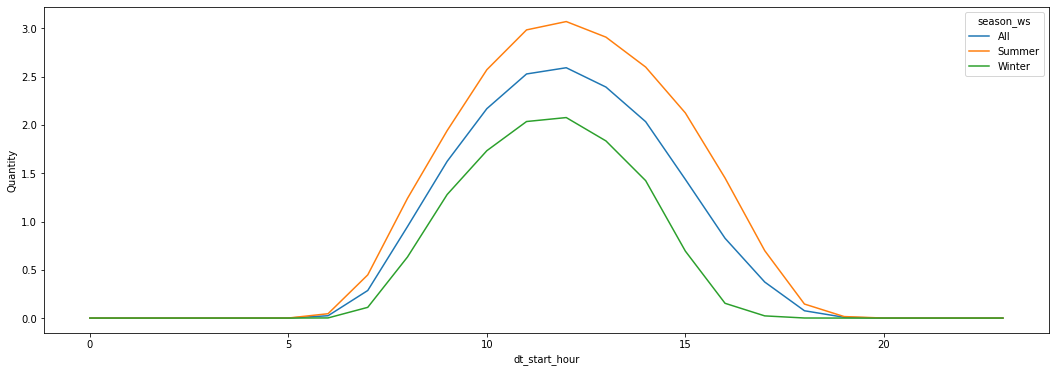

In [26]:
# Plot average daily trend

df_chart = df_avg_by_hour_ws.reset_index(drop=True) 

fig, ax = plt.subplots(figsize = (18,6))    

fig = sns.lineplot(data=df_chart, x='dt_start_hour', y='Quantity', hue='season_ws')

# Extras

In [28]:
df_ch = df_solar_data[['dt_start', 'dt_start_year', 'dt_start_month', 'dt_start_day', 
                       'dt_start_hour', 'dt_start_minute', 'dt_start_hrmin','Quantity']]

In [29]:
df_solar_data_sums_by_day.tail(7)

,dt_start_dt,Quantity,rolling_07,rolling_14,rolling_28,rolling_60
598,2023-01-11,23.05,10.015714,8.046429,NaN,NaN
599,2023-01-12,0.00,7.097143,NaN,NaN,NaN
600,2023-01-13,0.59,6.534286,NaN,NaN,NaN
601,2023-01-14,0.00,6.902857,NaN,NaN,NaN
602,2023-01-15,4.18,NaN,NaN,NaN,NaN
603,2023-01-16,3.18,NaN,NaN,NaN,NaN
604,2023-01-17,17.32,NaN,NaN,NaN,NaN


In [30]:
# Altair version (doesn't render in GitHub)

# Distribution of outputs by day (small bins)

ch_daily_hist = alt.Chart(df_solar_data_sums_by_day).mark_bar().encode(
    x = alt.X('Quantity', title='kWh', bin=alt.Bin(extent=[0, 40], step=1)), 
    y = alt.Y('count()', title='Days'))

ch_daily_hist.display()

alt.Chart(...)

In [31]:
# Distribution of outputs by day (larger bins)

ch_daily_hist = alt.Chart(df_solar_data_sums_by_day).mark_bar().encode(
    x = alt.X('Quantity', title='kWh', bin=alt.Bin(extent=[0, 40], step=4)), 
    y = alt.Y('count()', title='Days'))

ch_daily_hist.display()

alt.Chart(...)